# Vmat2-Cre analysis
Here we are invesigating the molecular properties of 151 somatosensory cortical Vmat2-Cre;tdTomato cells from two animals. 

In [1]:
# import necessary modules 
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import loompy

# make the text in figures editable in Illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
"""function for calculating the percentage of cells expressing gene of interest"""
def percentage_exp(adata, genes):
    per_list = []
    for gene in genes:
        percentage = len(adata[adata[:, gene].X > 0.25])/len(adata.X)
        per_list.append((gene, percentage*100))
    return sorted(per_list, key=lambda tup: tup[1], reverse = True)

"""function for calculating the number of cells expressing gene of interest"""
def number_exp(adata, genes):
    num_list = []
    for gene in genes:
        percentage = len(adata[adata[:, gene].X > 0.25])/len(adata.X)
        num_list.append((gene,percentage*len(adata.X)))
    return sorted(num_list, key=lambda tup: tup[1], reverse = True)

##
"""function for extracting the genes of interest depending on the category of receptor type from Guide to Pharmacology 'targets_and_families.csv'"""
def rec_type_list(prot_df, rec_type):
    prot_df = prot_df[prot_df['Type'] == rec_type] #isolate the data having the receptor type of interest from protein dataframe 
    prot_tuple = tuple(prot_df.loc[:,'MGI symbol'].dropna()); #making a tuple of the gene names från the protein name dataframe
    prot_list = [gene for gene in adata_w.var_names if gene.startswith(prot_tuple)] #to ensure gene in adata object, only have list with the genes existing in the adata object
    return prot_list

"""function for calculating the number of cells belonging to specific categorical observation"""
def calc_celltype_observation(adata, observation):
    pd_adata = pd.DataFrame(index = adata.obs_names, columns = adata.var_names, data = adata.X) #convert AnnData object to a dataframe. Does not work to make calculations directly on 
    #the AnnData object
    pd_adata['obs_name'] = adata.obs[observation] #create new column in dataframe depending on the target observation in the AnnData object
    pd_celltype = pd.DataFrame(pd_adata.loc[pd_adata.index, 'obs_name']) # extract the index and the target observation
    pd_celltype = pd.DataFrame(pd_adata.groupby('obs_name').size(), columns = ['number_cells']) #calculate the number of cells belonging to each category of the target observation
    return(pd_celltype)

In [3]:
# read the Vmat2-Cre dataset
adata_w = sc.read_loom('vmat2_sscortex.loom', sparse = False)
adata_w

AnnData object with n_obs × n_vars = 178 × 24582 
    obs: 'Animal', 'Experiment', 'Tissue'

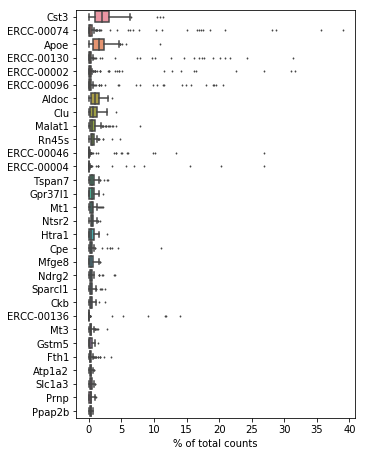

In [4]:
# general look at the highest expressed genes
sc.pl.highest_expr_genes(adata_w)

In [5]:
# detect the ERCC sequences. Save as observation
adata_w.var["ERCC"] = [True if gene.startswith("ERCC-") else False for gene in adata_w.var_names]
ERCC_genes = [gene for gene in adata_w.var_names if gene.startswith('ERCC')]
adata_w.obs['percent_ERCC_genes'] = np.sum(adata_w[:, ERCC_genes].X, axis=1)/ np.sum(adata_w.X, axis=1)
# detect mouse mitochondrial genes from www.ensemble.org. Save as observation
mito = set(sc.queries.mitochondrial_genes('mmusculus'))
adata_w.var["mito"] = [True if gene in mito else False for gene in adata_w.var_names]
# additional detection of mitochondrial genes. Add observation of calculated percentage of mitochondrial genes in each cell
mito_genes = [gene for gene in adata_w.var_names if gene.startswith('mt-')]
adata_w.obs['percent_mito_genes'] = np.sum(adata_w[:, mito_genes].X, axis=1)/ np.sum(adata_w.X, axis=1)
# add the total counts per cell as observation
adata_w.obs['n_counts'] = np.sum(adata_w.X, axis=1)

In [6]:
#calculate the general metrics and the metrics of ERCC and mitochondrial genes
sc.pp.calculate_qc_metrics(adata_w,qc_vars= ['ERCC', 'mito'], inplace=True)
#qc_vars= ['ERCC', 'mito']

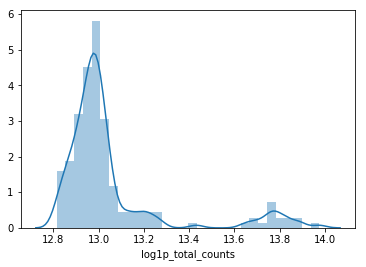

In [7]:
# plot the distribution of total counts in the adata_w object
sns.distplot(adata_w.obs['log1p_total_counts'])
f_count = adata_w.obs_vector('log1p_total_counts') > 11 # all cells having high logaritmized number of reads included

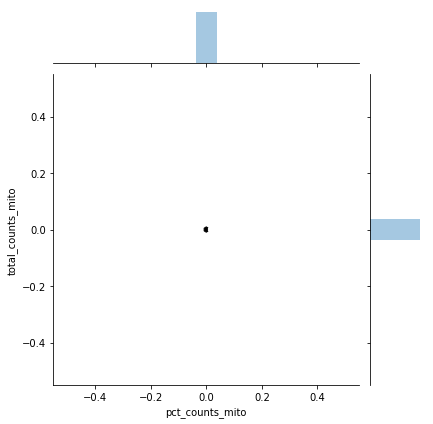

In [8]:
# plot the percentage of number of counts that are mitochondrial and total counts of mitochondrial genes. Mitochondrial genes not detected
sns.jointplot('pct_counts_mito', 'total_counts_mito', data=adata_w.obs, kind="hex")

C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


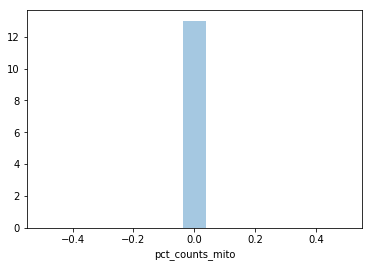

In [9]:
sns.distplot(adata_w.obs['pct_counts_mito'])
m_count = adata_w.obs_vector('pct_counts_mito') < 0.1

... storing 'Animal' as categorical
... storing 'Experiment' as categorical
... storing 'Tissue' as categorical


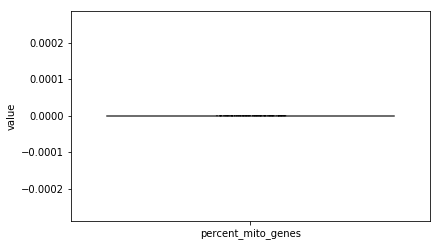

In [10]:
# plot the additional detection of mitochondrial genes in the AnnData object. Mitochondrial genes cannot be detected
sc.pl.violin(adata_w, 'percent_mito_genes')

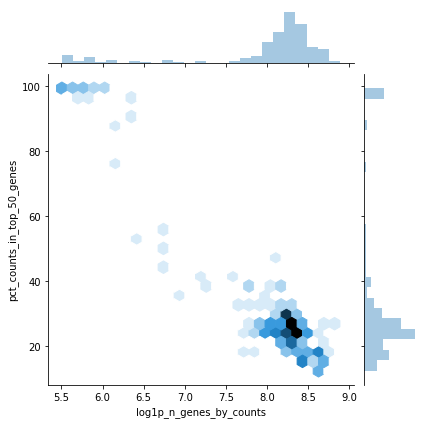

In [11]:
# plot the logaritmized number of genes by counts and the percentage of counts that express the top 50 most expressed genes
sns.jointplot('log1p_n_genes_by_counts', 'pct_counts_in_top_50_genes', data=adata_w.obs, kind="hex")
f_dist = adata_w.obs_vector('pct_counts_in_top_50_genes') < 80 # filter cells with distributed gene counts
f_capt = adata_w.obs_vector('log1p_n_genes_by_counts') > 6.0 # filter cells with broad gene capture

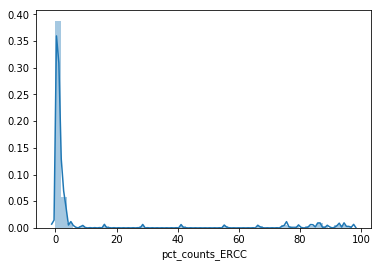

In [12]:
# plot the percentage of counts that are ERCC sequences
sns.distplot(adata_w.obs["pct_counts_ERCC"])
f_ercc = adata_w.obs_vector("pct_counts_ERCC") < 10 # cells with less than 10% ERCC counts included

In [13]:
# filter cells based on inclusion criteria
#f_count, f_dist, f_capt, f_ercc
f1 = np.logical_and(f_count, f_dist, m_count)
f2 = np.logical_and(f_capt, f_ercc)
f = np.logical_and(f1,f2)
print(adata_w.shape)

adata_w = adata_w[f]
# only include genes that are detected in more than 3 neurons
sc.pp.filter_genes(adata_w, min_cells=3)
print(adata_w.shape)

Trying to set attribute `.var` of view, making a copy.


(178, 24582)
(158, 18430)


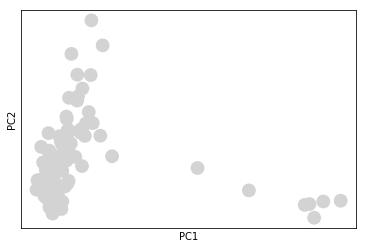

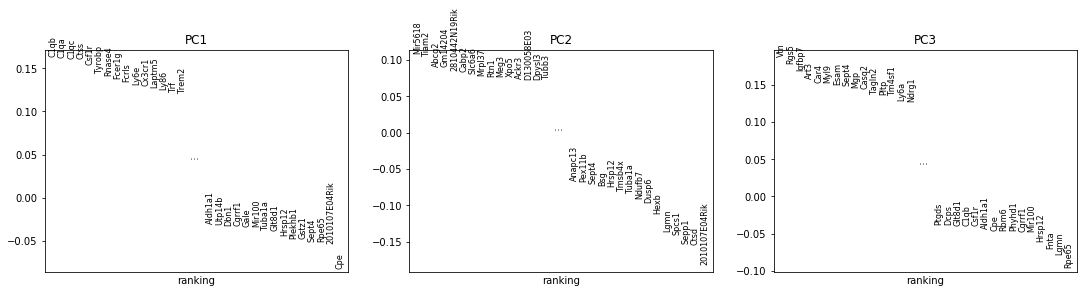

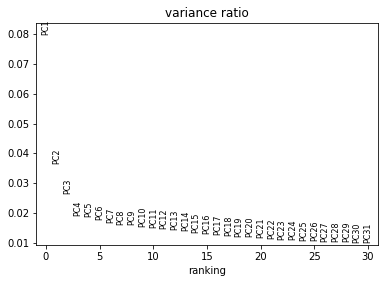

In [14]:
# normalize the number of reads per cell to the median number of reads
sc.pp.normalize_per_cell(adata_w, counts_per_cell_after= adata_w.obs['n_counts'].median())
# logaritmize data
sc.pp.log1p(adata_w)

# detect the most highest variable genes. Use for PCA
sc.pp.highly_variable_genes(adata_w, n_top_genes=1000, inplace=True)

# reduce dimensions of data
sc.pp.pca(adata_w, use_highly_variable=True)
sc.pl.pca_overview(adata_w)

## Clustering

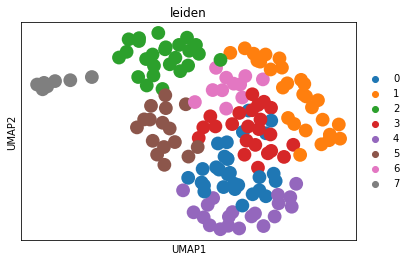

In [15]:
# compute the connectivity
sc.pp.neighbors(adata_w, n_neighbors=10, n_pcs=9)
sc.tl.umap(adata_w)

# cluster the neurons into subclusters
sc.tl.leiden(adata_w, resolution=1)
sc.pl.umap(adata_w, color = 'leiden')

In [16]:
sc.tl.rank_genes_groups(adata_w, groupby="leiden", n_genes=30)

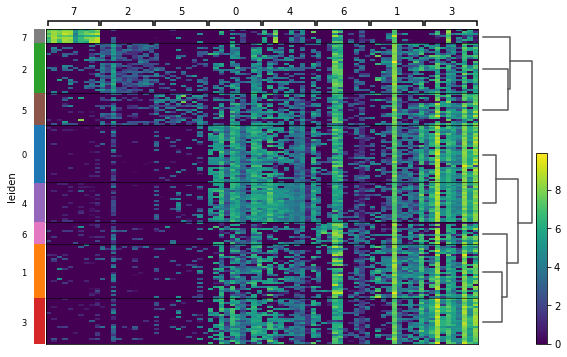

In [17]:
sc.tl.dendrogram(adata_w, groupby="leiden")
sc.pl.rank_genes_groups_heatmap(adata_w, n_genes=10)

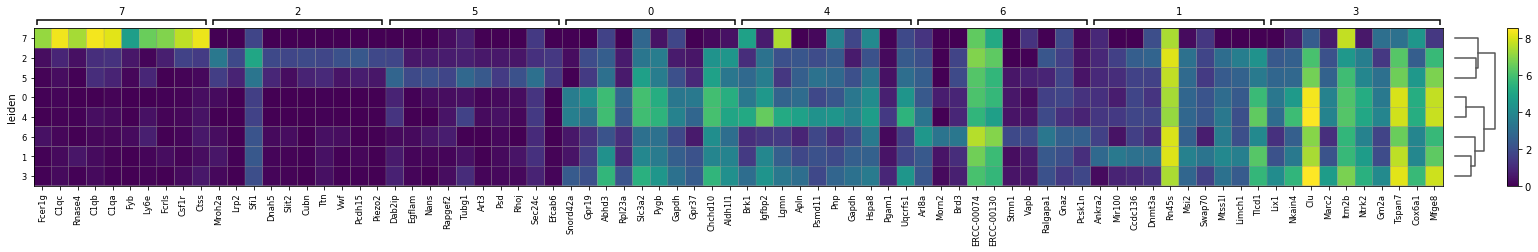

In [18]:
#fcer1g, C1qb, Ctss  is expressed by microglia (linnarson mousebrain atlas)
sc.pl.rank_genes_groups_matrixplot(adata_w, groupby="leiden", n_genes=10)

In [19]:
result = adata_w.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj']}).head(40)

,0_n,0_s,0_p,1_n,1_s,1_p,2_n,2_s,2_p,3_n,...,4_p,5_n,5_s,5_p,6_n,6_s,6_p,7_n,7_s,7_p
0,Snord42a,3.837217,0.74408,Ankra2,3.350881,0.917061,Mroh2a,9.275545,7.738191e-08,Lix1,...,0.579273,Dab2ip,3.569708,0.994616,Arl8a,3.082507,0.891974,Fcer1g,25.418564,1.703568e-07
1,Gpr19,3.814442,0.74408,Mir100,3.285786,0.917061,Lrp2,7.385275,9.053317e-05,Nkain4,...,0.579273,Egflam,3.291088,0.994616,Morn2,2.953545,0.891974,C1qc,23.709831,8.251086e-05
2,Abhd3,3.725592,0.74408,Ccdc136,3.105054,0.917061,Sfi1,7.239398,4.999612e-05,Clu,...,0.579273,Nans,3.279719,0.994616,Brd3,2.897295,0.891974,Rnase4,19.232559,7.192113e-06
3,Rpl23a,3.667274,0.74408,Dnmt3a,3.085383,0.917061,Dnah5,7.184771,8.594140e-05,Marc2,...,0.579273,Rapgef2,3.190447,0.994616,ERCC-00074,2.750598,0.891974,C1qb,17.878868,8.251086e-05
4,Slc3a2,3.610698,0.74408,Rn45s,3.029415,0.917061,Slit2,6.595925,4.678415e-04,Itm2b,...,0.579273,Tubg1,3.076004,0.994616,ERCC-00130,2.276344,0.891974,C1qa,17.687565,9.695950e-05
5,Pygb,3.484342,0.74408,Msi2,3.004234,0.917061,Cubn,6.546286,6.200987e-04,Ntrk2,...,0.579273,Art3,3.054521,0.994616,Stmn1,2.151803,0.891974,Fyb,17.323542,7.192113e-06
6,Gapdh,3.430902,0.74408,Swap70,2.647323,0.917061,Ttn,6.530723,1.708452e-04,Gm2a,...,0.579273,Psd,2.929863,0.994616,Vapb,2.145236,0.891974,Ly6e,15.053866,5.772457e-04
7,Gpr37,3.426074,0.74408,Mtss1l,2.592134,0.917061,Vwf,6.513513,6.461246e-04,Tspan7,...,0.579273,Rhoj,2.911966,0.994616,Ralgapa1,2.065975,0.891974,Fcrls,14.735673,2.771694e-05
8,Chchd10,3.417236,0.74408,Limch1,2.577426,0.917061,Pcdh15,6.438953,6.461246e-04,Cox6a1,...,0.579273,Sec24c,2.897998,0.994616,Gnaz,2.050374,0.891974,Csf1r,14.452173,2.746265e-05
9,Aldh1l1,3.378709,0.74408,Tlcd1,2.567490,0.917061,Piezo2,6.125011,1.734057e-03,Mfge8,...,0.579273,Efcab6,2.881099,0.994616,Pcsk1n,2.046624,0.891974,Ctss,13.783426,3.146148e-05


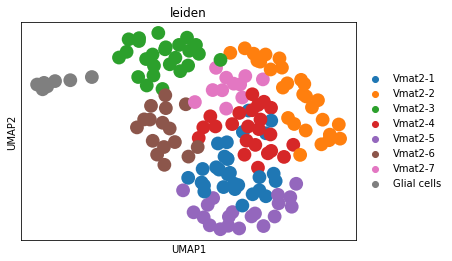

In [20]:
#reassign and plot the cluster names
new_cluster_names = [
    'Vmat2-1', 'Vmat2-2',
    'Vmat2-3', 'Vmat2-4',
    'Vmat2-5', 'Vmat2-6',
    'Vmat2-7','Glial cells']
adata_w.rename_categories('leiden', new_cluster_names)
sc.pl.umap(adata_w, color="leiden", save= 'Vmat2_umap_leiden_unprocc.pdf')

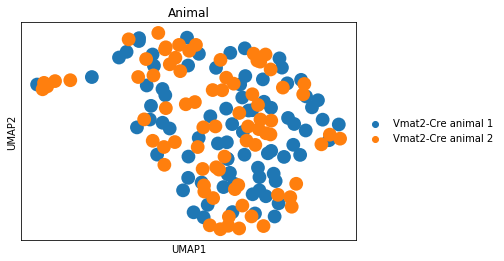

In [21]:
#reassign and plot the animal names
new_cluster_names_animals = [
    'Vmat2-Cre animal 1', 'Vmat2-Cre animal 2']
adata_w.rename_categories('Animal', new_cluster_names_animals)
sc.pl.umap(adata_w, color="Animal", save= 'Vmat2_umap_animals_unprocc.pdf')

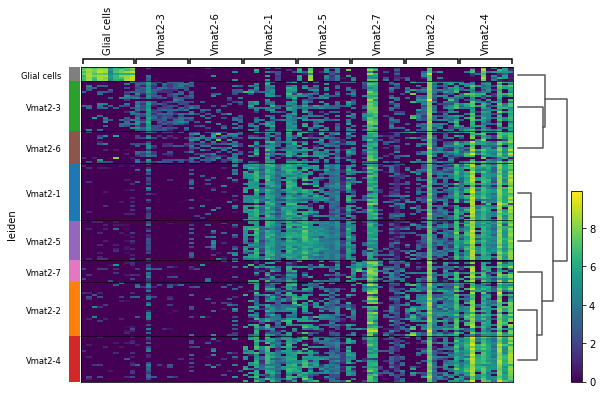

In [22]:
sc.pl.rank_genes_groups_heatmap(adata_w, n_genes=10, save = 'Vmat2_heatmap_unprocc.pdf')

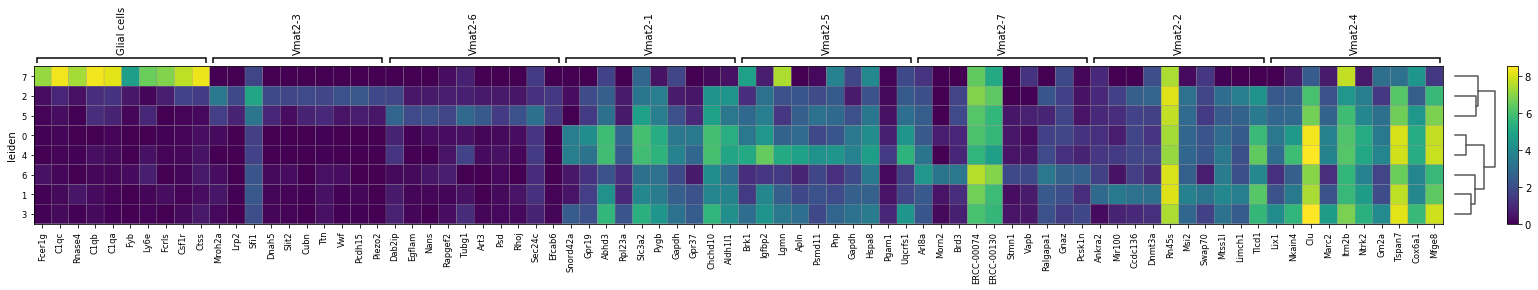

In [23]:
sc.pl.rank_genes_groups_matrixplot(adata_w, groupby="leiden", n_genes=10, save = 'Vmat2_matrix_unprocc.pdf')

In [24]:
not_microglia = [False if group == "Glial cells" else True for group in adata_w.obs["leiden"]]
adata_w = adata_w[not_microglia]

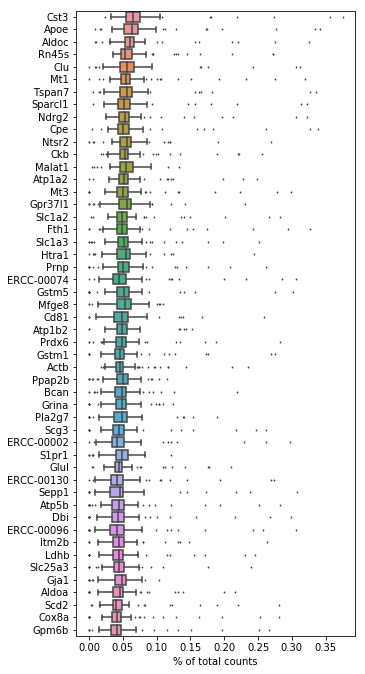

In [25]:
sc.pl.highest_expr_genes(adata_w, n_top = 50, save ='Vmat2_highest_exp_genes.pdf')

Trying to set attribute `.var` of view, making a copy.


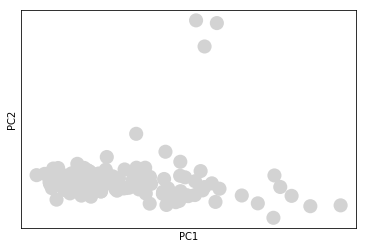

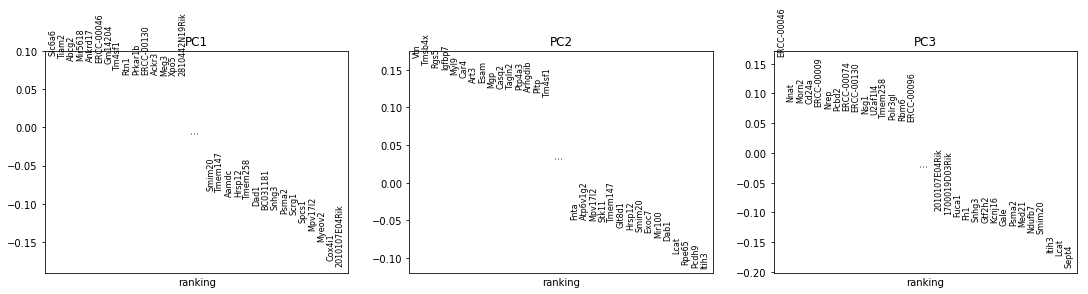

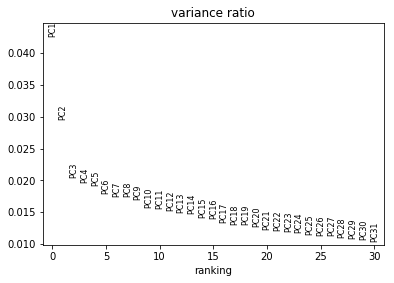

In [26]:
sc.pp.highly_variable_genes(adata_w, n_top_genes=1000, inplace=True)

sc.pp.pca(adata_w, use_highly_variable=True)
sc.pl.pca_overview(adata_w)

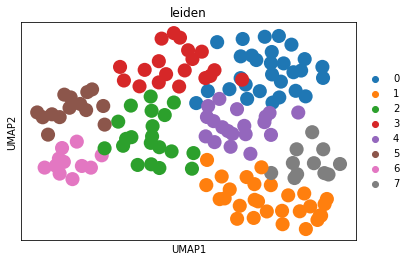

In [27]:
sc.pp.neighbors(adata_w, n_neighbors=10, n_pcs=9)
sc.tl.umap(adata_w)

sc.tl.leiden(adata_w, resolution=1)
sc.pl.umap(adata_w, color= 'leiden')

adata_w_red = adata_w

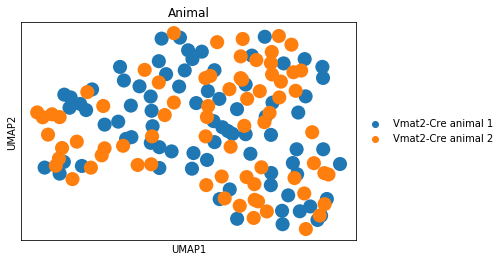

In [28]:
sc.pl.umap(adata_w, color= 'Animal', save ='Vmat2_UMAP_procc_animals.pdf')

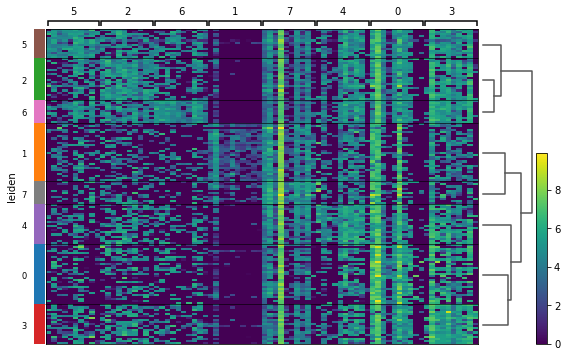

In [29]:
sc.tl.rank_genes_groups(adata_w, groupby="leiden", n_genes=30)
sc.tl.dendrogram(adata_w, groupby="leiden")
sc.pl.rank_genes_groups_heatmap(adata_w, n_genes=10)

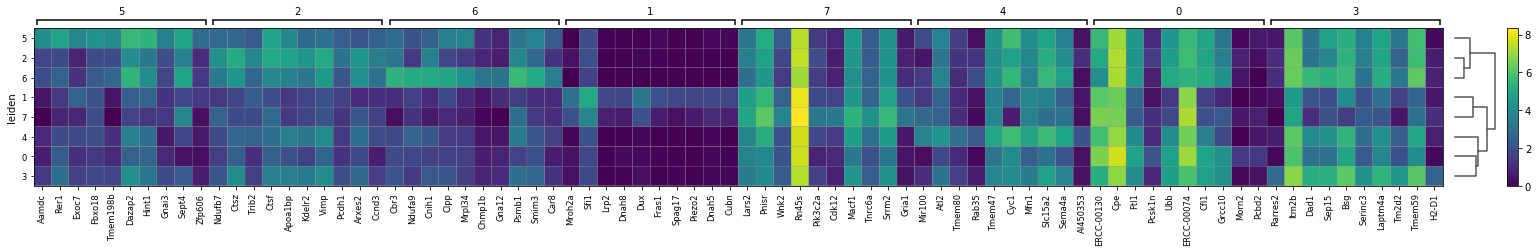

In [30]:
sc.pl.rank_genes_groups_matrixplot(adata_w, groupby="leiden", n_genes=10)

In [31]:
result = adata_w.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame({group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'scores', 'pvals_adj']}).head(40)

,0_n,0_s,0_p,1_n,1_s,1_p,2_n,2_s,2_p,3_n,...,4_p,5_n,5_s,5_p,6_n,6_s,6_p,7_n,7_s,7_p
0,ERCC-00130,3.422177,0.714774,Mroh2a,8.359562,6.956293e-07,Ndufb7,3.298530,0.883577,Rarres2,...,0.903025,Aamdc,4.322733,0.917739,Cbr3,4.843102,0.876992,Lars2,3.527689,0.942478
1,Cpe,3.182888,0.714774,Sfi1,7.951914,2.551877e-06,Ctsz,3.298182,0.883577,Itm2b,...,0.903025,Rer1,4.223228,0.917739,Ndufa9,4.540457,0.876992,Pnisr,3.301408,0.942478
2,Ftl1,3.020025,0.714774,Lrp2,7.307609,6.123624e-05,Trib2,3.267533,0.883577,Dad1,...,0.903025,Exoc7,3.936109,0.917739,Cnih1,4.153971,0.876992,Wnk2,3.128484,0.942478
3,Pcsk1n,2.741149,0.714774,Dnah8,7.297258,6.123624e-05,Ctsf,3.173201,0.883577,Sep15,...,0.903025,Fbxo18,3.639461,0.917739,Clpp,4.101625,0.876992,Rn45s,3.024423,0.942478
4,Ubb,2.694131,0.714774,Dux,7.274073,4.312718e-05,Apoa1bp,3.123054,0.883577,Bsg,...,0.903025,Tmem198b,3.621147,0.917739,Mrpl34,3.824418,0.876992,Pik3c2a,3.005992,0.942478
5,ERCC-00074,2.542870,0.714774,Fras1,7.025918,1.400763e-04,Kdelr2,3.120881,0.883577,Serinc3,...,0.903025,Dazap2,3.486186,0.917739,Chmp1b,3.781712,0.876992,Cdk12,2.996444,0.942478
6,Cfl1,2.498789,0.714774,Spag17,6.698794,2.979430e-04,Vimp,3.084744,0.883577,Laptm4a,...,0.903025,Hint1,3.432804,0.917739,Gna12,3.775295,0.876992,Macf1,2.988582,0.942478
7,Grcc10,2.247355,0.714774,Piezo2,6.543379,3.081891e-04,Pcdh1,3.054100,0.883577,Tm2d2,...,0.903025,Gnai3,3.275112,0.917739,Psmb1,3.773856,0.876992,Tnrc6a,2.987689,0.942478
8,Morn2,2.202132,0.714774,Dnah5,6.447430,2.065041e-04,Arxes2,3.036444,0.883577,Tmem59,...,0.903025,Sept4,3.238672,0.917739,Smim3,3.713049,0.876992,Srrm2,2.897802,0.942478
9,Pcbd2,2.171006,0.714774,Cubn,6.383683,2.979430e-04,Ccnd3,2.988550,0.883577,H2-D1,...,0.903025,Zfp606,3.122823,0.917739,Car8,3.691662,0.876992,Gria1,2.868410,0.942478


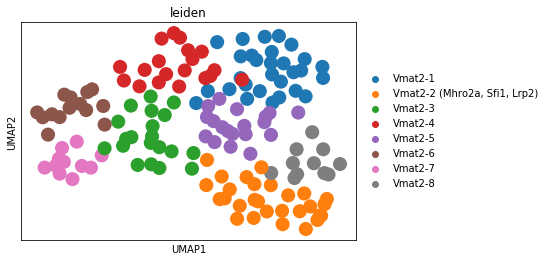

In [33]:
#reassign the cluster names
new_cluster_names_procc = [
    'Vmat2-1', 'Vmat2-2 (Mhro2a, Sfi1, Lrp2)',
    'Vmat2-3', 'Vmat2-4',
    'Vmat2-5', 'Vmat2-6',
    'Vmat2-7', 'Vmat2-8']

adata_w.rename_categories('leiden', new_cluster_names_procc)
sc.pl.umap(adata_w, color= 'leiden', save = 'Vmat2_UMAP_procc_leiden.pdf' )

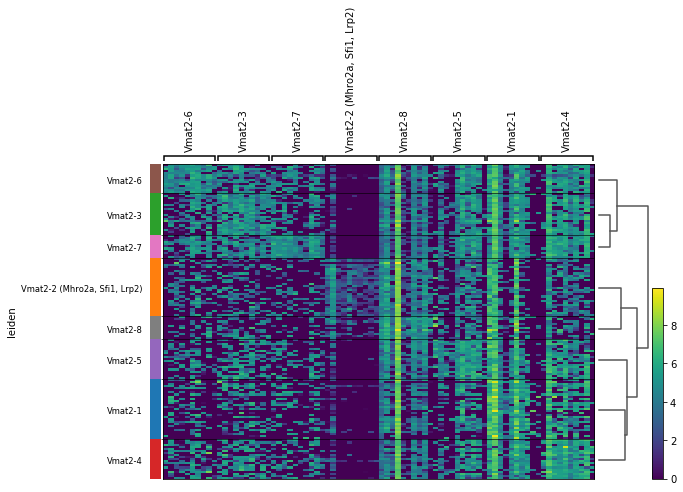

In [34]:
sc.tl.rank_genes_groups(adata_w, groupby="leiden", n_genes=30)
sc.tl.dendrogram(adata_w, groupby="leiden")
sc.pl.rank_genes_groups_heatmap(adata_w, n_genes=10, save = 'Vmat2_heatmap_procc_leiden.pdf')

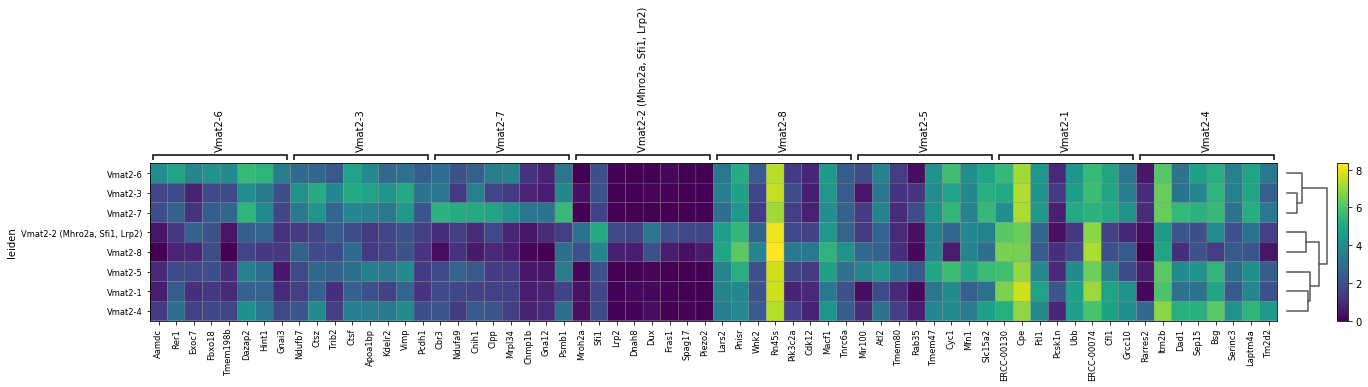

In [35]:
sc.pl.rank_genes_groups_matrixplot(adata_w, groupby="leiden", n_genes=8, save = 'Vmat2_matrix_procc.pdf')

## Specific gene expression analysis

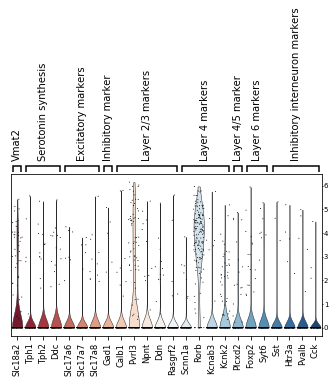

In [36]:
group_labels = ['Vmat2', 'Serotonin synthesis', 'Excitatory markers', 'Inhibitory marker', 
              'Layer 2/3 markers', 'Layer 4 markers', 'Layer 4/5 marker', 'Layer 6 markers',
               'Inhibitory interneuron markers']
group_position = [(0,0), (1,3), (4,6), (7,7), (8,12),(13,16),(17,17), (18,19), (20,23)]

marker_genes = ['Slc18a2', 'Tph1', 'Tph2', 'Ddc', 'Slc17a6', 'Slc17a7', 'Slc17a8', 'Gad1',
                'Calb1', 'Pvrl3', 'Npnt', 'Ddn', 'Rasgrf2', 'Scnn1a', 'Rorb',
                'Kcnab3', 'Kcnk2','Plcxd2', 'Foxp2', 'Syt6', 'Sst', 'Htr3a','Pvalb', 'Cck']

sc.pl.stacked_violin(adata_w, var_names = marker_genes, var_group_labels = group_labels, var_group_positions = group_position,
                     stripplot = True, jitter = 0.4, palette = "RdBu", save = 'Vmat2_violin_target_genes.pdf')

# Inhibitory markers Viaat (Slc32a1), VIP not detected

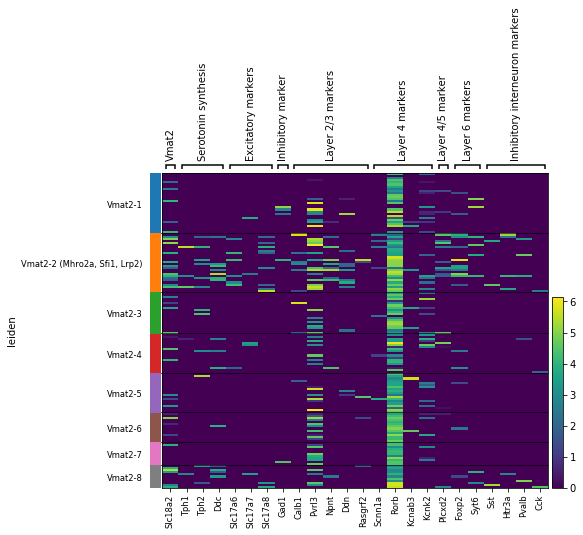

GridSpec(2, 4, height_ratios=[0.15, 6], width_ratios=[0.2, 7.199999999999999, 0, 0.2])

In [37]:
sc.pl.heatmap(adata_w, marker_genes, groupby='leiden', var_group_labels = group_labels, var_group_positions = group_position, save = 'vmat2_heatmap_marker_genes.pdf')

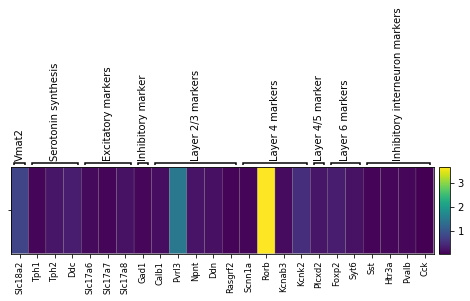

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[7.68, 0, 0.2])

In [38]:
sc.pl.matrixplot(adata_w, var_names = marker_genes, var_group_labels = group_labels, var_group_positions = group_position,
                save = 'Vmat2_matrixplot_target_genes.pdf')

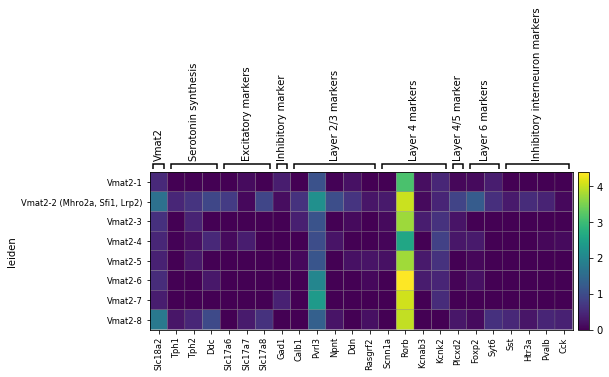

GridSpec(2, 3, height_ratios=[0.5, 10], width_ratios=[7.68, 0, 0.2])

In [39]:
sc.pl.matrixplot(adata_w, groupby= 'leiden', var_names = marker_genes, var_group_labels = group_labels, var_group_positions = group_position,
                save = 'Vmat2_matrixplot_groups_target_genes.pdf')

In [40]:
percentage_exp(adata_w_red, marker_genes)

C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\core\anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


[('Rorb', 92.71523178807946),
 ('Pvrl3', 40.397350993377486),
 ('Slc18a2', 25.165562913907287),
 ('Kcnk2', 23.841059602649008),
 ('Foxp2', 11.258278145695364),
 ('Ddc', 9.933774834437086),
 ('Plcxd2', 9.933774834437086),
 ('Tph2', 7.9470198675496695),
 ('Ddn', 7.9470198675496695),
 ('Slc17a8', 7.28476821192053),
 ('Npnt', 7.28476821192053),
 ('Calb1', 5.960264900662252),
 ('Syt6', 5.298013245033113),
 ('Slc17a6', 4.635761589403973),
 ('Scnn1a', 4.635761589403973),
 ('Kcnab3', 4.635761589403973),
 ('Tph1', 3.3112582781456954),
 ('Slc17a7', 3.3112582781456954),
 ('Gad1', 3.3112582781456954),
 ('Rasgrf2', 3.3112582781456954),
 ('Htr3a', 3.3112582781456954),
 ('Pvalb', 3.3112582781456954),
 ('Sst', 1.9867549668874174),
 ('Cck', 1.9867549668874174)]

In [41]:
number_exp(adata_w_red, marker_genes)

C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\core\anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


[('Rorb', 140.0),
 ('Pvrl3', 61.0),
 ('Slc18a2', 38.0),
 ('Kcnk2', 36.0),
 ('Foxp2', 17.0),
 ('Ddc', 14.999999999999998),
 ('Plcxd2', 14.999999999999998),
 ('Tph2', 12.0),
 ('Ddn', 12.0),
 ('Slc17a8', 11.0),
 ('Npnt', 11.0),
 ('Calb1', 9.0),
 ('Syt6', 8.0),
 ('Slc17a6', 7.0),
 ('Scnn1a', 7.0),
 ('Kcnab3', 7.0),
 ('Tph1', 5.0),
 ('Slc17a7', 5.0),
 ('Gad1', 5.0),
 ('Rasgrf2', 5.0),
 ('Htr3a', 5.0),
 ('Pvalb', 5.0),
 ('Sst', 3.0),
 ('Cck', 3.0)]

In [42]:
# importing protein datatbase file from UniProt
targets_families = pd.read_csv('targets_and_families.csv')
targets_families.head()

,Type,Family id,Family name,Target id,Target name,Subunits,Target systematic name,Target abbreviated name,synonyms,HGNC id,...,Rat SwissProt,Rat Entrez Gene,MGI id,MGI symbol,MGI name,Mouse genetic localisation,Mouse nucleotide RefSeq,Mouse protein RefSeq,Mouse SwissProt,Mouse Entrez Gene
0,gpcr,1,5-Hydroxytryptamine receptors,1,5-HT<sub>1A</sub> receptor,NaN,NaN,NaN,ADRBRL1|5-HT1A|ADRB2RL1|serotonin receptor 1A|...,5286,...,P19327,24473,MGI:96273,Htr1a,5-hydroxytryptamine (serotonin) receptor 1A,13 D2.1,NM_008308,NP_032334,Q64264,15550
1,gpcr,1,5-Hydroxytryptamine receptors,2,5-HT<sub>1B</sub> receptor,NaN,NaN,NaN,5-HT1B|5-HT1DB|HTR1D2|5-HT1B serotonin recepto...,5287,...,P28564,25075,MGI:96274,Htr1b,5-hydroxytryptamine (serotonin) receptor 1B,9 E1,NM_010482,NP_034612,P28334,15551
2,gpcr,1,5-Hydroxytryptamine receptors,3,5-HT<sub>1D</sub> receptor,NaN,NaN,NaN,5-HT<sub>1D&alpha;</sub>|HTRL|5-HT1D|HT1DA|ser...,5289,...,P28565,25323,MGI:96276,Htr1d,5-hydroxytryptamine (serotonin) receptor 1D,4 D3,NM_008309,NP_032335,Q61224,15552
3,gpcr,1,5-Hydroxytryptamine receptors,4,5-ht<sub>1e</sub> receptor,NaN,NaN,NaN,5-HT<sub>1E</sub><sub>&alpha;</sub>|5-HT1E|5-h...,5291,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,gpcr,1,5-Hydroxytryptamine receptors,5,5-HT<sub>1F</sub> receptor,NaN,NaN,NaN,5-HT<sub>1E&beta;</sub>|5-HT<sub>6</sub>|5-HT1...,5292,...,P30940,60448,MGI:99842,Htr1f,5-hydroxytryptamine (serotonin) receptor 1F,16 C1.3,NM_008310,NP_032336,Q02284,15557


In [43]:
#lists of all genes from target receptor type
gpcr_list = rec_type_list(targets_families, 'gpcr')
lgic_list = rec_type_list(targets_families, 'lgic')

In [44]:
percent_lgic = pd.DataFrame(percentage_exp(adata_w, lgic_list), columns = ['gene_name', 'percent'])
print(percent_lgic[:51])

top_lgig = percent_lgic['gene_name'][:41]

C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\core\anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


   gene_name    percent
0      Gria2  93.377483
1     Grin2c  93.377483
2     Gabrb1  86.092715
3      Itpr2  80.794702
4     Gabrg1  66.887417
5      Grik5  54.304636
6       Glrb  51.655629
7     Gabra2  42.384106
8     Grin2b  38.410596
9     Gabra4  35.099338
10     Gria1  32.450331
11     P2rx7  27.152318
12     P2rx4  26.490066
13     Grid2  26.490066
14     Itpr1  25.165563
15     Asic2  24.503311
16     Grid1  24.503311
17    Grin3a  19.867550
18     Grik3  12.582781
19   Grid2ip  11.920530
20    Gabra5  11.258278
21     Itpr3  11.258278
22     Grik1  10.596026
23     Grik2   9.933775
24     Asic1   9.933775
25     Glra1   9.271523
26     Gabre   8.609272
27    Gabrb2   8.609272
28     Gria3   7.947020
29     Gabrq   7.947020
30    Gabrr2   7.284768
31    Gabrg3   7.284768
32     Grik4   7.284768
33    Gabra1   7.284768
34    Grin2a   7.284768
35     Grin1   6.622517
36    Chrnb2   6.622517
37     Htr3b   6.622517
38    Grin3b   6.622517
39     P2rx1   6.622517
40    Chrna2   6

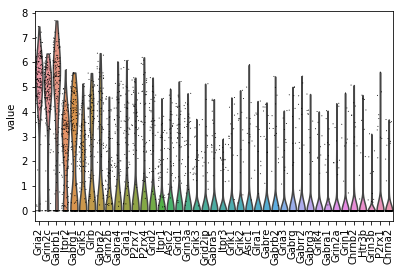

In [45]:
sc.pl.violin(adata_w, top_lgig, stripplot = True, jitter = 0.4, rotation = 90, save = 'Vmat2_violin_lgic_input.pdf')

In [46]:
percent_gpcr = pd.DataFrame(percentage_exp(adata_w, gpcr_list), columns = ['gene_name', 'percent'])
print(percent_gpcr[:51])
top_gpcr = percent_gpcr['gene_name'][:41]

C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\anndata\core\anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


    gene_name    percent
0       Ntsr2  98.675497
1     Gpr37l1  98.013245
2       S1pr1  98.013245
3        Grm3  93.377483
4      Gabbr1  87.417219
5       Ednrb  84.768212
6        Smox  80.132450
7        Fzd2  79.470199
8   Adcyap1r1  76.821192
9        Rhoa  73.509934
10     Gprc5b  69.536424
11       Lgr4  68.211921
12     Gpr146  68.211921
13       Rhob  67.549669
14     Celsr2  63.576159
15      Rhot1  60.927152
16     Gpr162  56.953642
17       Lgr6  56.291391
18       Rhoq  54.966887
19      Gpr19  52.317881
20      Gpr37  51.655629
21       Rhou  49.668874
22       Hrh1  47.682119
23     Gpr107  46.357616
24       Fzd1  46.357616
25    Rhobtb2  45.033113
26    Adora2b  41.059603
27     Celsr1  40.397351
28       Fzd9  36.423841
29     Adora1  35.761589
30     Gabbr2  35.761589
31     Gpr108  33.112583
32      Tpra1  32.450331
33     Gpr155  31.788079
34    Rhobtb3  31.125828
35     Gpr137  31.125828
36      Lpar6  29.139073
37       Rhoc  28.476821
38      Rhot2  27.152318


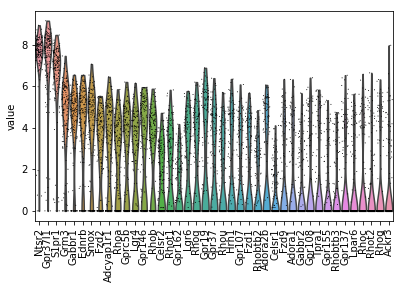

In [47]:
sc.pl.violin(adata_w, top_gpcr, stripplot= True, jitter = 0.4, rotation = 90, fig_size = (10,20), save = 'vmat2_violin_gpcr_input.pdf')
#sns.set(font_scale = 0.9)

## Prediction of location and cell types of Vmat2-Cre neurons 
Dataset from Zeisel et al. Obtained through 10x

In [48]:
# open the Zeisel et al dataset
adata_z_proj = sc.read_loom('l6_r3_telencephalon_projecting_neurons.loom', sparse = False)
adata_z_proj

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


AnnData object with n_obs × n_vars = 28858 × 27998 
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascular', 'Cl

In [49]:
# make the observations and gene names unique
adata_z_proj.obs_names_make_unique()
adata_z_proj.var_names_make_unique()

In [50]:
print(calc_celltype_observation(adata_z_proj, 'Probable_location'))

                                                    number_cells
obs_name                                                        
Anterior olfactory nucleus and ventral striatum               89
Anterior olfactory nucleus, deep layer                       657
Basolateral amygdala                                         958
CA1                                                         2037
CA1 (posterior),subiculum,entorhinal                         104
CA3                                                          484
Cingulate/Retrosplenial area, layer 2                        598
Cingulate/Retrosplenial area, layer 5                        202
Cingulate/Retrosplenial area, layer 6                        402
Cortex pyramidal layer 5, Cingulate/Retrospleni...           664
Cortex pyramidal layer 6                                    2789
Cortex pyramidal layer 6b                                    274
Cortical pyramidal (poor markers)                           1464
Cortical pyramidal layer 

In [51]:
adata_z_cortex = adata_z_proj[adata_z_proj.obs['Region'] == 'Cortex']
adata_z_cortex

View of AnnData object with n_obs × n_vars = 15216 × 27998 
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascul

In [52]:
cor_pyr = [name for name in adata_z_cortex.obs['Probable_location'] if name.startswith('Cort')]
cor_pyr_exc = [name for name in adata_z_cortex.obs['Probable_location'] if name.startswith(('Cortical pyramidal (poo', 'Cortex pyramidal layer 5, Cingul'))]
cor_pyr_exc

adata_z_cortex.obs['pyr_cell'] = adata_z_cortex.obs['Probable_location'].isin(cor_pyr).astype(str)
adata_z_cortex = adata_z_cortex[adata_z_cortex.obs['pyr_cell'] == 'True']
adata_z_cortex.obs['bad_cells'] = adata_z_cortex.obs['Probable_location'].isin(cor_pyr_exc).astype(str)


adata_z = adata_z_cortex[adata_z_cortex.obs['bad_cells'] == 'False']

Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


In [53]:
adata_z.var['mito'] = [True if gene in mito else False for gene in adata_z.var_names]
adata_z.var['ERCC'] = [True if gene.startswith('ERCC-') else False for gene in adata_z.var_names]
adata_z.obs['n_counts'] =  np.sum(adata_z.X, axis = 1)

Trying to set attribute `.var` of view, making a copy.


In [54]:
sc.pp.calculate_qc_metrics(adata_z, qc_vars= ['mito', 'ERCC'], inplace=True)

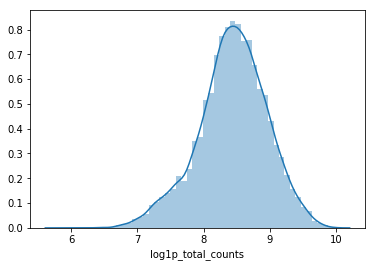

In [55]:
sns.distplot(adata_z.obs['log1p_total_counts'])
f_count = adata_z.obs_vector('log1p_total_counts') > 7

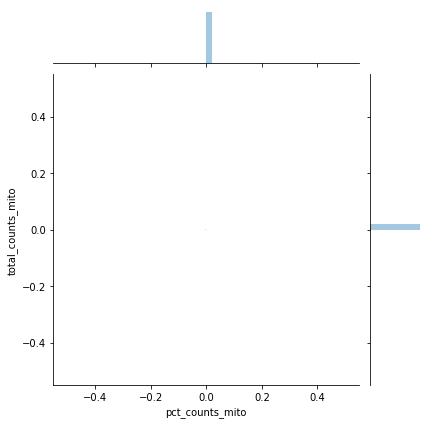

In [56]:
sns.jointplot('pct_counts_mito', 'total_counts_mito', data=adata_z.obs, kind="hex")
f_mito = adata_z.obs_vector('pct_counts_mito') < 0.1

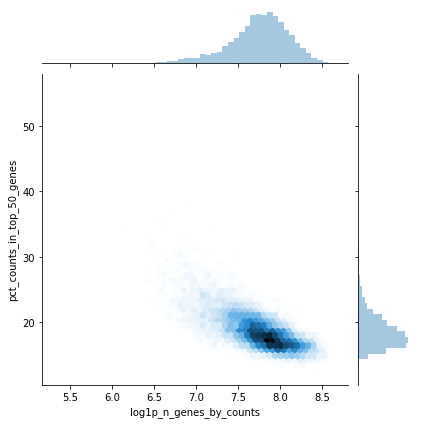

In [57]:
sns.jointplot('log1p_n_genes_by_counts', 'pct_counts_in_top_50_genes', data=adata_z.obs, kind="hex")
f_dist = adata_z.obs_vector('pct_counts_in_top_50_genes') < 40 # filter cells with distributed gene counts
f_capt = adata_z.obs_vector('log1p_n_genes_by_counts') > 6.0 # filter cells with broad gene capture

In [58]:
#f_count, f_dist, f_capt, f_mito
f3 = np.logical_and(f_count, f_dist)
f4 = np.logical_and(f_capt, f_mito)
f5 = np.logical_and(f3,f4)
print(adata_z.shape)
adata_z = adata_z[f5]
sc.pp.filter_genes(adata_z, min_cells=3)
print(adata_z.shape)

(9435, 27998)


Trying to set attribute `.var` of view, making a copy.


(9369, 17304)


In [59]:
sc.pp.normalize_per_cell(adata_z, counts_per_cell_after=np.median(np.apply_over_axes(np.sum, adata_z.X, axes=1)))
sc.pp.log1p(adata_z)

In [60]:
#merge the two datasets based on all genes. Genes not expressed in the other dataset will be set as zero
adata_merged = adata_z.concatenate(adata_w, join= 'outer', batch_categories= ['Zeisel', 'Vmat2-Cre'])
adata_merged.X = np.nan_to_num(adata_merged.X)

#make the observation names unique
adata_merged.obs_names_make_unique()
adata_merged.var_names_make_unique()

... storing 'Age' as categorical
... storing 'AnalysisPool' as categorical
... storing 'AnalysisProject' as categorical
... storing 'Animal' as categorical
... storing 'Bucket' as categorical
... storing 'CellConc' as categorical
... storing 'Cell_Conc' as categorical
... storing 'ChipID' as categorical
... storing 'Class' as categorical
... storing 'ClusterName' as categorical
... storing 'Comment' as categorical
... storing 'Comments' as categorical
... storing 'DateCaptured' as categorical
... storing 'Date_Captured' as categorical
... storing 'Description' as categorical
... storing 'Developmental_compartment' as categorical
... storing 'DonorID' as categorical
... storing 'Estimated Number of Cells' as categorical
... storing 'Experiment' as categorical
... storing 'Flowcell' as categorical
... storing 'Fraction Reads in Cells' as categorical
... storing 'Label' as categorical
... storing 'Location_based_on' as categorical
... storing 'Mean Reads per Cell' as categorical
... stori

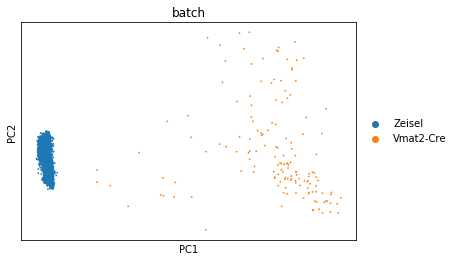

In [61]:
sc.pp.pca(adata_merged) # have to use this to get two dimensions of the data
sc.pl.pca_scatter(adata_merged, color= 'batch', save = 'Vmat2_zeisel_pca_scatter_unprocc.pdf')

#make the observation names unique
adata_merged.obs_names_make_unique()
adata_merged.var_names_make_unique()

In [62]:
#adata_z_norm = adata[adata.obs['batch'] == 'Zeisel']
sc.pp.highly_variable_genes(adata_z, n_top_genes=5000)
#adata_z_h = adata_z_norm[:, adata_z_norm.var['highly_variable']]

#adata_h_norm = adata[adata.obs['batch'] == 'Haring']
sc.pp.highly_variable_genes(adata_w, n_top_genes=5000)
#adata_h_h = adata_h_norm[:, adata_h_norm.var['highly_variable']]

joined_adata = adata_w.concatenate(adata_z, join = 'inner', batch_categories= ['Vmat2-Cre', 'Zeisel'])
joined_HVG = list(joined_adata.var_names)

In [63]:
adata_z_s = sc.pp.scale(adata_z, copy = True)
adata_w_s = sc.pp.scale(adata_w, copy = True)

In [64]:
adata_corr = (sc.external.pp.mnn_correct(adata_z_s[:, joined_HVG], adata_w_s[:, joined_HVG], batch_categories = ['Zeisel', 'Vmat2-Cre'], do_concatenate= True))[0]
adata_corr

C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\mnnpy\utils.py:14: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "l2_norm" failed type inference due to: Invalid use of Function(<function norm at 0x0000022A8FFA6BF8>) with argument(s) of type(s): (axis=Literal[int](1), x=array(float32, 2d, A))
 * parameterized
In definition 0:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from C:\Users\hanwe868\AppData\Roaming\Python\Python36\site-packages\numba\typing\templates.py:539
In definition 1:
    TypeError: norm_impl() got an unexpected keyword argument 'x'
    raised from C:\Users\hanwe868\AppData\Roaming\Python\Python36\site-packages\numba\typing\templates.py:539
This error is usually caused by passing an argument of a type that is unsupported by the named function.
[1] During: resolving callee type: Function(<function norm at 0x0000022A8FFA6BF8>)
[2] During: typing of call at C:\Users\h

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...


C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\mnnpy\utils.py:88: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "find_mutual_nn" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\mnnpy\utils.py (94)

File "..\..\..\AppData\Local\Continuum\anaconda3\lib\site-packages\mnnpy\utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, n_jobs):
    <source elided>
    mutual_2 = []
    for index_2 in range(data2.shape[0]):
    ^

  @jit((float32[:, :], float32[:, :], int8, int8, int8))
C:\Users\hanwe868\AppData\Roaming\Python\Python36\site-packages\numba\object_mode_passes.py:178: NumbaWarning: Function "find_mutual_nn" was compiled in object mode without forceobj=True.

File "..\..\..\AppData\Local\Continuum\anaconda3\lib\site-packages\mnnpy\utils.py", line 94:
def find_mutual_nn(data1, data2, k1, k2, 

  Computing correction vectors...


C:\Users\hanwe868\AppData\Roaming\Python\Python36\site-packages\numba\ir_utils.py:2030: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'mnn2' of function 'compute_correction'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "..\..\..\AppData\Local\Continuum\anaconda3\lib\site-packages\mnnpy\utils.py", line 107:
def compute_correction(data1, data2, mnn1, mnn2, data2_or_raw2, sigma):
    <source elided>
    vect_reduced = np.zeros((data2.shape[0], vect.shape[1]), dtype=np.float32)
    for index, ve in zip(mnn2, vect):
    ^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
C:\Users\hanwe868\AppData\Local\Continuum\anaconda3\lib\site-packages\mnnpy\utils.py:102: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function compute_correction fa

  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...
Packing AnnData object...
Done.


AnnData object with n_obs × n_vars = 9520 × 14425 
    obs: 'Age', 'AnalysisPool', 'AnalysisProject', 'Animal', 'Bucket', 'CellConc', 'Cell_Conc', 'ChipID', 'Class', 'ClassProbability_Astrocyte', 'ClassProbability_Astrocyte,Immune', 'ClassProbability_Astrocyte,Neurons', 'ClassProbability_Astrocyte,Oligos', 'ClassProbability_Astrocyte,Vascular', 'ClassProbability_Bergmann-glia', 'ClassProbability_Blood', 'ClassProbability_Blood,Vascular', 'ClassProbability_Enteric-glia', 'ClassProbability_Enteric-glia,Cycling', 'ClassProbability_Ependymal', 'ClassProbability_Ex-Neurons', 'ClassProbability_Ex-Vascular', 'ClassProbability_Immune', 'ClassProbability_Immune,Neurons', 'ClassProbability_Immune,Oligos', 'ClassProbability_Neurons', 'ClassProbability_Neurons,Cycling', 'ClassProbability_Neurons,Oligos', 'ClassProbability_Neurons,Satellite-glia', 'ClassProbability_Neurons,Vascular', 'ClassProbability_OEC', 'ClassProbability_Oligos', 'ClassProbability_Oligos,Cycling', 'ClassProbability_Oligos,Vascu

... storing 'Age' as categorical
... storing 'AnalysisPool' as categorical
... storing 'AnalysisProject' as categorical
... storing 'Animal' as categorical
... storing 'Bucket' as categorical
... storing 'CellConc' as categorical
... storing 'Cell_Conc' as categorical
... storing 'ChipID' as categorical
... storing 'Class' as categorical
... storing 'ClusterName' as categorical
... storing 'Comment' as categorical
... storing 'Comments' as categorical
... storing 'DateCaptured' as categorical
... storing 'Date_Captured' as categorical
... storing 'Description' as categorical
... storing 'Developmental_compartment' as categorical
... storing 'DonorID' as categorical
... storing 'Estimated Number of Cells' as categorical
... storing 'Experiment' as categorical
... storing 'Flowcell' as categorical
... storing 'Fraction Reads in Cells' as categorical
... storing 'Label' as categorical
... storing 'Location_based_on' as categorical
... storing 'Mean Reads per Cell' as categorical
... stori

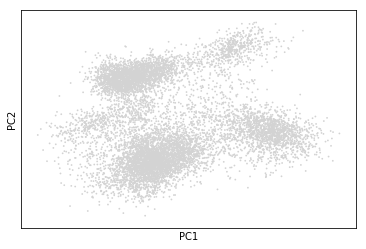

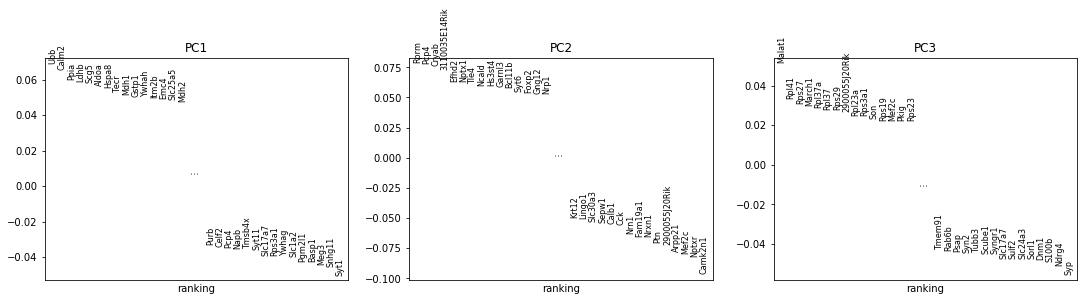

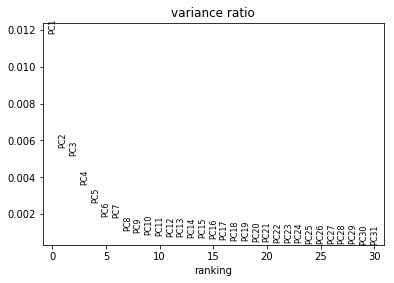

In [65]:
sc.pp.pca(adata_corr)
sc.pl.pca_overview(adata_corr)

In [66]:
sc.pp.neighbors(adata_corr, n_neighbors= 10, n_pcs= 9)
sc.tl.umap(adata_corr)

C:\Users\hanwe868\AppData\Roaming\Python\Python36\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\AppData\Local\Continuum\anaconda3\lib\site-packages\umap\rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
C:\Users\hanwe868\AppData\Roaming\Python\Python36\site-packages\numba\typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "..\..\..\AppData\

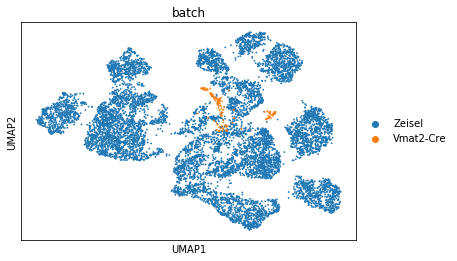

In [67]:
sc.pl.umap(adata_corr, color = 'batch',save = 'umap_zeisel_Vmat2_procc.pdf')

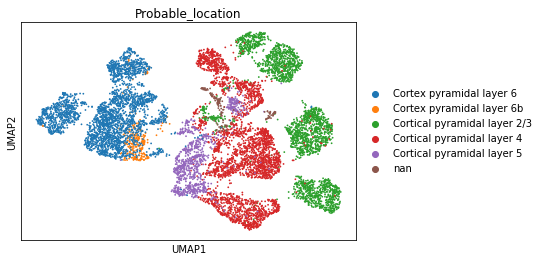

In [68]:
sc.pl.umap(adata_corr, color = 'Probable_location',save = 'umap_zeisel_Vmat2_loc_procc.pdf')
#make the observation names unique
adata_corr.obs_names_make_unique()
adata_corr.var_names_make_unique()

In [69]:
print(calc_celltype_observation(adata_corr, 'Probable_location'))

                              number_cells
obs_name                                  
Cortex pyramidal layer 6              2765
Cortex pyramidal layer 6b              273
Cortical pyramidal layer 2/3          2421
Cortical pyramidal layer 4            3048
Cortical pyramidal layer 5             862
nan                                    151


In [70]:
# create testing datasets
train_X = adata_corr.X[adata_corr.obs["batch"] == "Zeisel", :]
train_y = adata_corr.obs["Probable_location"][adata_corr.obs["batch"] == "Zeisel"].values
test_X = adata_corr.X[adata_corr.obs["batch"] == "Vmat2-Cre", :]

In [107]:
from sklearn import linear_model
#evaluating linear SGDClassifier
model_sgd = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, loss = 'log')
model_sgd.fit(train_X, train_y)
print('SDGClassifier:', (model_sgd.score(train_X, train_y)))
labels = model_sgd.predict(test_X)
prob = model_sgd.predict_proba(adata_corr.X)

SDGClassifier: 0.9835628135339951


In [108]:
prob = np.max(prob, axis = 1)

In [109]:
adata_corr.obs["Probable_location"][adata_corr.obs["batch"] == "Vmat2-Cre"] = labels
adata_corr.obs["probability"] = prob

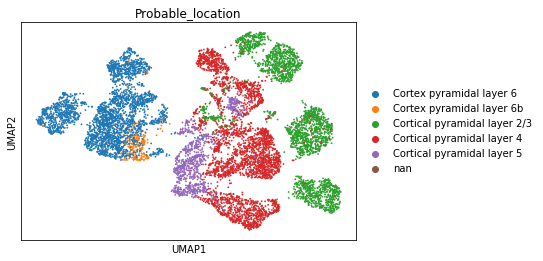

In [110]:
sc.pl.umap(adata_corr, color = 'Probable_location', save = 'umap_zeisel_vmat2_batch_anntotated_procc.pdf')

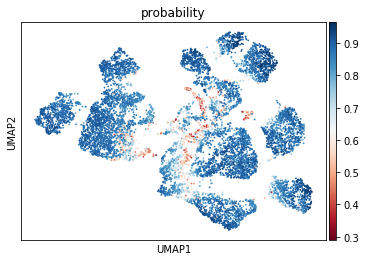

In [111]:
sc.pl.umap(adata_corr, color = 'probability', color_map = 'RdBu', save = 'umap_zeisel_vmat2_probability_procc.pdf')

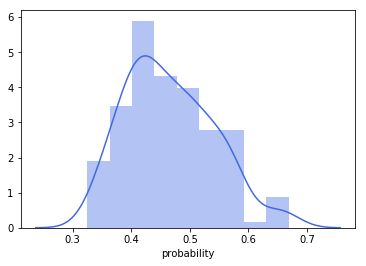

In [112]:
adata_corr_vmat2 = adata_corr[adata_corr.obs['batch'] == 'Vmat2-Cre']
distplot_prob_loc = sns.distplot(adata_corr_vmat2.obs['probability'])
plt.show()
fig = distplot_prob_loc.get_figure()
fig.savefig('distplot_prob_loc.pdf')

In [113]:
adata_w.obs_names = adata_corr_vmat2.obs_names
adata_w.obs_names

adata_w.obs['Probable_location'] = adata_corr_vmat2.obs['Probable_location']

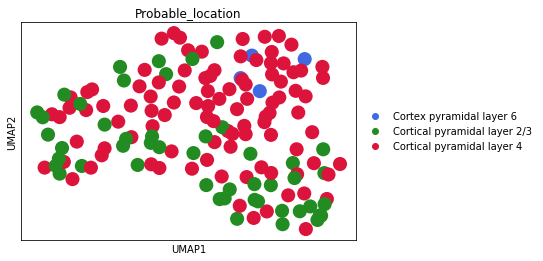

In [114]:
colors_loc = ['royalblue', 'forestgreen', 'crimson']
sns.set_palette(sns.color_palette(colors_loc))
sc.pl.umap(adata_w, color='Probable_location', palette= colors_loc, save = 'umap_vmat2_annotated_locations.pdf')

In [115]:
calc_Vmat = calc_celltype_observation(adata_w, 'Probable_location')
print(calc_Vmat)

print((calc_Vmat/len(adata_w.obs_names))*100)

                              number_cells
obs_name                                  
Cortex pyramidal layer 6                 4
Cortical pyramidal layer 2/3            48
Cortical pyramidal layer 4              99
                              number_cells
obs_name                                  
Cortex pyramidal layer 6          2.649007
Cortical pyramidal layer 2/3     31.788079
Cortical pyramidal layer 4       65.562914


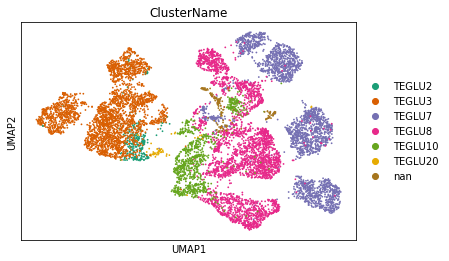

In [117]:
colors = sns.palettes.color_palette("Dark2", n_colors=7)
sc.pl.umap(adata_corr, color = 'ClusterName', palette = colors, save = 'umap_zeisel_Vmat2_cluster_procc.pdf')
#make the observation names unique
adata_corr.obs_names_make_unique()
adata_corr.var_names_make_unique()

In [121]:
# create testing datasets
train_X_2 = adata_corr.X[adata_corr.obs["batch"] == "Zeisel", :]
train_y_2 = adata_corr.obs["ClusterName"][adata_corr.obs["batch"] == "Zeisel"].values
test_X_2 = adata_corr.X[adata_corr.obs["batch"] == "Vmat2-Cre", :]

In [128]:
#evaluating linear SGDClassifier
model_sgd = linear_model.SGDClassifier(max_iter=1000, tol=1e-3, loss = 'log')
model_sgd.fit(train_X_2, train_y_2)
print('SDGClassifier:', (model_sgd.score(train_X_2, train_y_2)))
labels_2 = model_sgd.predict(test_X_2)
prob_2 = model_sgd.predict_proba(adata_corr.X)

SDGClassifier: 0.978866474543708


In [129]:
prob_2 = np.max(prob_2, axis = 1)

In [130]:
adata_corr.obs["ClusterName"][adata_corr.obs["batch"] == "Vmat2-Cre"] = labels_2
adata_corr.obs["probability_2"] = prob_2

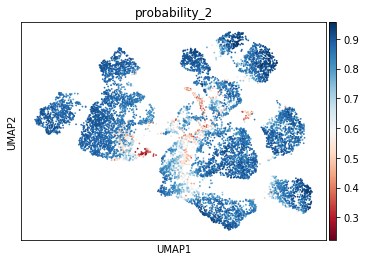

In [131]:
sc.pl.umap(adata_corr, color = 'probability_2', color_map = 'RdBu', save = 'umap_zeisel_vmat2_probability_cluster.pdf')

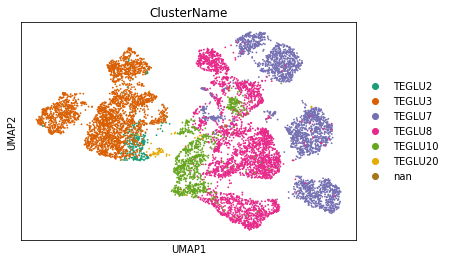

In [132]:
sc.pl.umap(adata_corr, color = 'ClusterName', palette = colors, save = 'umap_zeisel_vmat2_cluster_annot.pdf')

In [133]:
adata_corr_vmat2_2 = adata_corr[adata_corr.obs['batch'] == 'Vmat2-Cre']
adata_w.obs_names = adata_corr_vmat2_2.obs_names
adata_w.obs_names

adata_w.obs['ClusterName'] = adata_corr_vmat2_2.obs['ClusterName']
calc_Vmat_cluster = calc_celltype_observation(adata_w, 'ClusterName')
print(calc_Vmat_cluster)

print((calc_Vmat_cluster/len(adata_w.obs_names))*100)

          number_cells
obs_name              
TEGLU3               6
TEGLU7              50
TEGLU8              94
TEGLU10              1
          number_cells
obs_name              
TEGLU3        3.973510
TEGLU7       33.112583
TEGLU8       62.251656
TEGLU10       0.662252


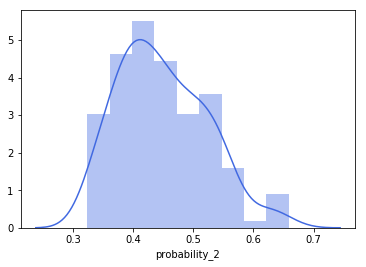

In [134]:
distplot_prob_cluster = sns.distplot(adata_corr_vmat2_2.obs['probability_2'])
plt.show()
fig_cluster = distplot_prob_cluster.get_figure()
fig_cluster.savefig('distplot_prob_cluster.pdf')

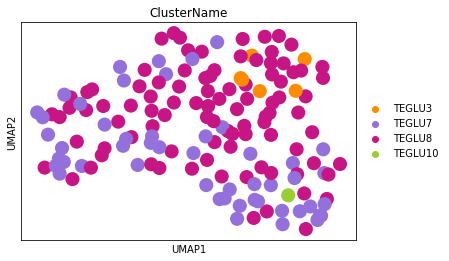

In [135]:
colors_clu = ['darkorange', 'mediumpurple', 'mediumvioletred', 'yellowgreen']
sns.set_palette(sns.color_palette(colors_clu))
sc.pl.umap(adata_w, color='ClusterName', palette= colors_clu, save = 'umap_vmat2_annotated_clusters.pdf')